# Adaptive-IPP with Non-Point FoV

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import tensorflow as tf
from time import time

# Import updated sgptools modules
from sgptools.utils.metrics import get_reconstruction, get_rmse
from sgptools.utils.data import Dataset
from sgptools.core.osgpr import init_osgpr
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params, optimize_model
from sgptools.methods import ContinuousSGP
from sgptools.core.transformations import IPPTransform, SquareHeightTransform
from gpflow.utilities import print_summary
from sgptools.utils.misc import get_inducing_pts
import gpflow

# Plotting libraries
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import mpl_toolkits.mplot3d.art3d as art3d
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

# Set random seeds for reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

2025-06-27 17:26:39.326835: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 17:26:39.332845: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 17:26:39.346642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751063199.367909    8851 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751063199.373502    8851 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751063199.392703    8851 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
def get_vertices(Xu, X_fov):
    """
    Utility to map the inducing points to FoV vertices.
    """
    X_fov = X_fov.reshape(len(Xu), -1, 2)
    vertices = np.zeros((len(Xu), 5, 2))
    vertices[:, 0] = X_fov.min(axis=1)
    vertices[:, 1] = np.array([X_fov[:, :, 0].min(axis=1),
                              X_fov[:, :, 1].max(axis=1)]).T
    vertices[:, 2] = X_fov.max(axis=1)
    vertices[:, 3] = np.array([X_fov[:, :, 0].max(axis=1),
                              X_fov[:, :, 1].min(axis=1)]).T
    vertices[:, 4] = X_fov.mean(axis=1)

    dists = pairwise_distances(vertices[:, 4], Y=Xu[:, :2],
                               metric='euclidean')
    _, idx = linear_sum_assignment(dists)

    vertices[:, 4] = Xu[idx][:, :2]
    return vertices

def plot_results(X_inducing, X_fov, current_idx=0, fname=None):
    """
    Method to plot the solution with FoVs and environment reconstruction.
    """
    # Setup 3D plot
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

    current_idx += 1 # Increment by one for plotting

    # Plot the reconstructed environment state
    num_fov_pts = len(X_fov)//len(X_inducing)
    sensor_data = dataset.get_sensor_data(X_fov[:num_fov_pts*(current_idx)], 
                                          max_samples=1500)
    y_pred, _ = get_reconstruction(sensor_data, dataset.get_test()[0],
                                   noise_variance_opt, kernel_opt)
    y_train_min, y_train_max = dataset.get_train()[1].min(), dataset.get_train()[1].max()
    norm = colors.Normalize(y_train_min, y_train_max)
    test_dim_shape = int(np.sqrt(dataset.get_test()[0].shape[0]))
    _ = ax.plot_surface(dataset.get_test()[0][:, 0].reshape(test_dim_shape, test_dim_shape),
                        dataset.get_test()[0][:, 1].reshape(test_dim_shape, test_dim_shape),
                        np.atleast_2d(-0.1),
                        facecolors=plt.cm.jet(norm(y_pred.reshape(test_dim_shape, test_dim_shape))),
                        shade=False,
                        alpha=0.8,
                        zorder=0)

    # Plot the solution path
    ax.scatter(X_inducing[:current_idx, 0],
               X_inducing[:current_idx, 1],
               X_inducing[:current_idx, 2], c='C3')
    ax.scatter(X_inducing[current_idx:, 0],
               X_inducing[current_idx:, 1],
               X_inducing[current_idx:, 2], c='C2')
    ax.plot(X_inducing[:, 0], X_inducing[:, 1], X_inducing[:, 2], 'k-')

    # Plot the FoV vertices
    vertices = get_vertices(X_inducing, X_fov)
    for i in range(vertices.shape[0]):
        color = 'C3' if i < current_idx else 'C2'
        verts = []
        verts.append([vertices[i, 0], vertices[i, 1],
                      vertices[i, 2], vertices[i, 3]])
        fov = Polygon(np.array(verts)[0, :, :2],
                      linewidth=1.5,
                      edgecolor=color,
                      facecolor=color,
                      fill=False,
                      zorder=15)
        ax.add_patch(fov)
        art3d.pathpatch_2d_to_3d(fov)

    # Configure other plot settings
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.set_xlim(np.min(dataset.get_train()[0][:, 0])-0.5, np.max(dataset.get_train()[0][:, 0])+0.5)
    ax.set_ylim(np.min(dataset.get_train()[0][:, 1])-0.5, np.max(dataset.get_train()[0][:, 1])+0.5)
    ax.set_zlim(0, 14)

    ax.view_init(elev=30, azim=45+180)
    ax.set_title(f'Waypoint: {current_idx}, RMSE: {get_rmse(y_pred, dataset.get_test()[1]):.2f}\nData Field Reconstruction', y=0.99)

    plt.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    plt.show()

In [3]:
def run_aipp(X_train, ipp_model, Xu_init, dataset):
    """
    Method to run AIPP using the SGP-based approach.
    """
    total_time_param = 0
    total_time_ipp = 0
    num_robots = Xu_init.shape[0]
    num_waypoints = Xu_init.shape[1]
    curr_sol = Xu_init.copy()
    
    # Get the initial expanded path for plotting
    expanded_path = ipp_model.transform.expand(curr_sol.reshape(-1, 3), 
                                               expand_sensor_model=False)
    if not isinstance(expanded_path, np.ndarray):
        expanded_path = expanded_path.numpy()

    plot_results(expanded_path,
                 ipp_model.transform.expand(curr_sol.reshape(-1, 3)).numpy())

    # Initialize the hyperparameters and SSGP
    init_kernel, init_noise_variance = ipp_model.get_hyperparameters()
    param_model = init_osgpr(X_train,
                             num_inducing=40,
                             kernel=init_kernel,
                             noise_variance=init_noise_variance)

    sol_data_X = []
    sol_data_y = []
    for time_step in range(num_waypoints):
        # Get a new batch of data from the last visited waypoint
        last_visited = curr_sol[:, time_step].copy()
        
        # Apply the sensor model expansion with fixed points IPP expansion
        data_pts = ipp_model.transform.sensor_model.expand(tf.constant(last_visited)).numpy()
        data_X_batch, data_y_batch = dataset.get_sensor_data(data_pts)
        sol_data_X.extend(data_X_batch)
        sol_data_y.extend(data_y_batch)

        # Skip param and path update for the last waypoint
        if time_step == num_waypoints - 1:
            break

        # Update the SSGP hyperparameter model
        param_model.update((np.array(data_X_batch),
                            np.array(data_y_batch)),
                           update_inducing=True)
        # Train only the kernel parameters and noise variance.
        start_time = time()
        optimize_model(param_model,
                       trainable_variables=param_model.trainable_variables)
        end_time = time()
        total_time_param += end_time - start_time
        print_summary(param_model.kernel)
        print_summary(param_model.likelihood)

        # Update the SGP-IPP model
        Xu_visited = curr_sol.copy()[:, :time_step + 1]
        ipp_model.transform.update_Xu_fixed(Xu_visited)
        ipp_model.update(param_model.kernel, 
                         param_model.likelihood.variance.numpy())
        start_time = time()
        
        # Optimize the IPP model
        curr_sol = ipp_model.optimize(verbose=False)
        end_time = time()
        total_time_ipp += end_time - start_time
        
        # Get the expanded path for plotting
        expanded_path = ipp_model.transform.expand(tf.constant(curr_sol.reshape(-1, 3)), 
                                                   expand_sensor_model=False)
        if not isinstance(expanded_path, np.ndarray):
            expanded_path = expanded_path.numpy()

        plot_results(expanded_path,
                     ipp_model.transform.expand(tf.constant(curr_sol.reshape(-1, 3))).numpy(),
                     time_step + 1)

    return np.array(sol_data_X), np.array(sol_data_y), total_time_param, total_time_ipp

## Generate synthetic data and initial SGP hyperparameters

Original dataset shape: (75, 75)
Training data shapes (X, y): (1000, 2), (1000, 1)
Testing data shapes (X, y): (5625, 2), (5625, 1)
Candidate data shape (X): (150, 2)
Dataset loaded and preprocessed successfully.
Optimized Hyperparameters


2025-06-27 17:26:46.635257: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.7033403704257706  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [2.37268 2.22137]   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.01167667636009361 │


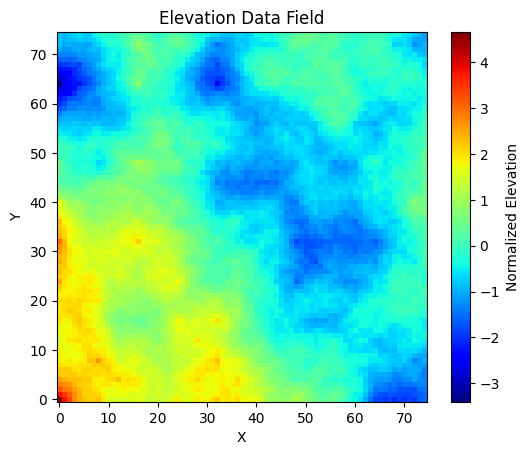

In [4]:
# Get the synthetic elevation data using the new Dataset class
dataset = Dataset(random_seed=0,
                  shape=(75, 75),
                  num_test=75*75)
X_train, y_train = dataset.get_train()
X_test, y_test = dataset.get_test()

# Train a GP and get the model parameters
print('Optimized Hyperparameters')
_, noise_variance_opt, kernel_opt = get_model_params(X_train, y_train,
                                                     lengthscales=[1.0, 1.0],
                                                     optimizer='scipy.L-BFGS-B')

# Plot the data field
test_dim_shape = int(np.sqrt(X_test.shape[0]))
plt.imshow(y_test.reshape(test_dim_shape, test_dim_shape), cmap="jet", origin='lower')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Elevation Data Field')
plt.colorbar(label='Normalized Elevation')
plt.show()

## Generate the AIPP solution

Initial AIPP Hyperparameters
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.0                 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [1. 1.]             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ flo

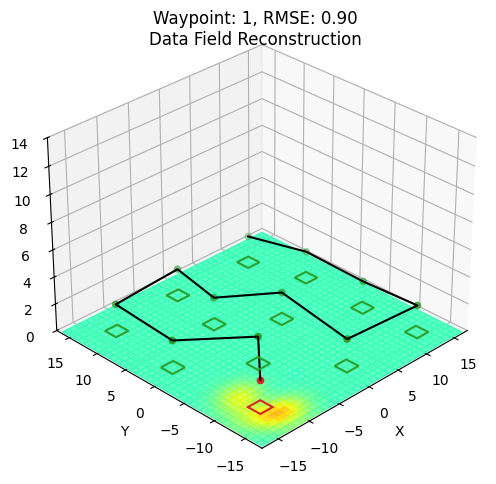

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.18438328324116898     │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [3.01719    0.88161738] │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤

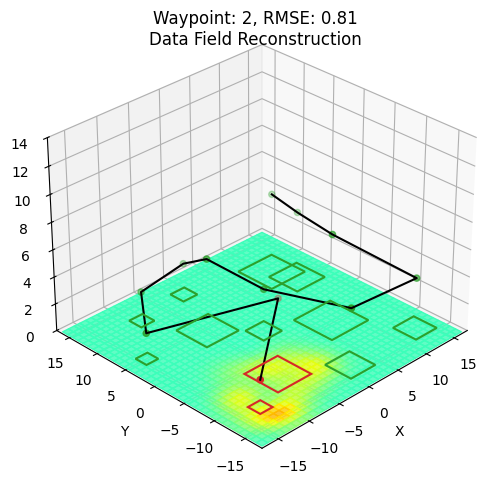

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.38906579338806146 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [1.79882 3.14691]   │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤════════

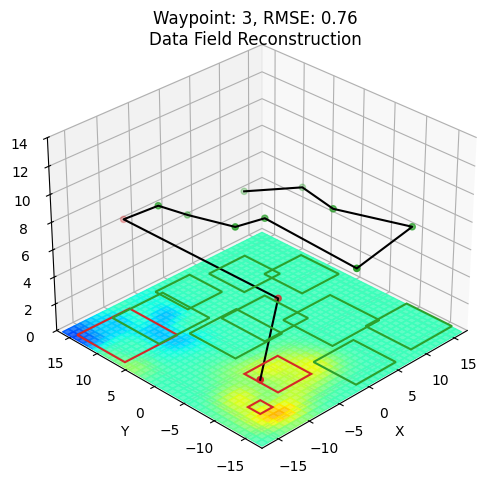

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.3664671665535966 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [2.52146 3.88939]  │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ 

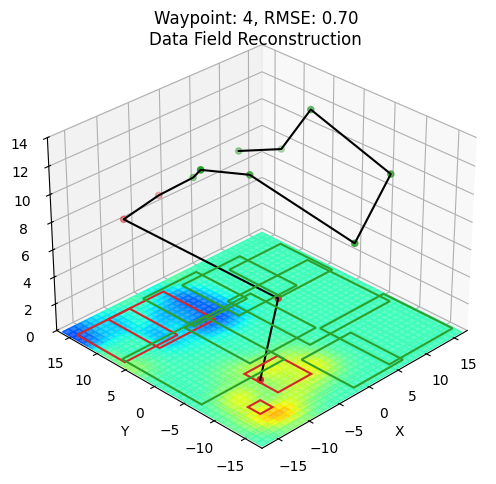

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.4458166015818531 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [1.2181  5.75679]  │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ 

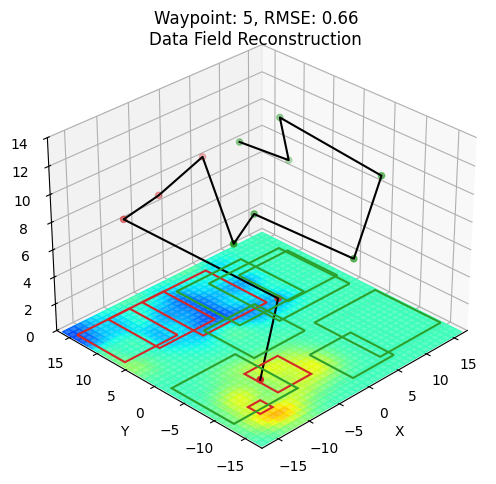

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                   │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.5594245410389153      │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [0.95508105 5.94368   ] │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤

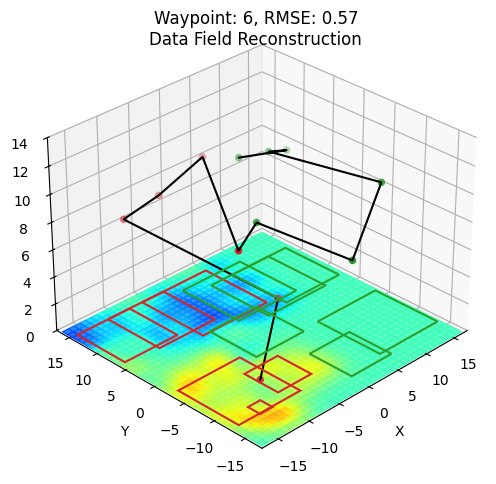

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.98554           │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [2.42912 4.8539 ] │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name   

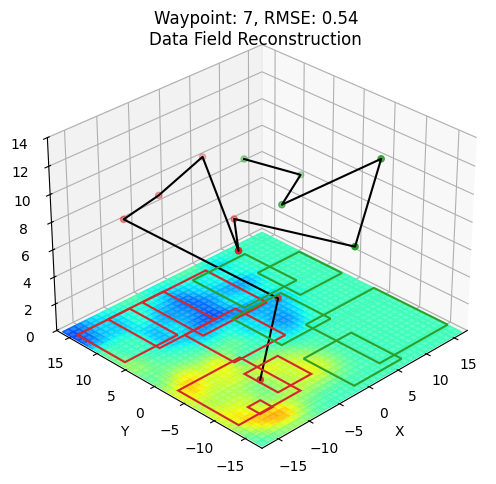

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.7727999224109817 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [2.22791 2.64839]  │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ n

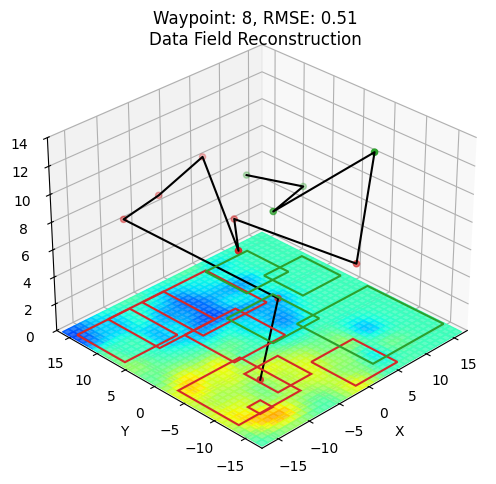

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.01879           │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [2.77771 3.52015] │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name   

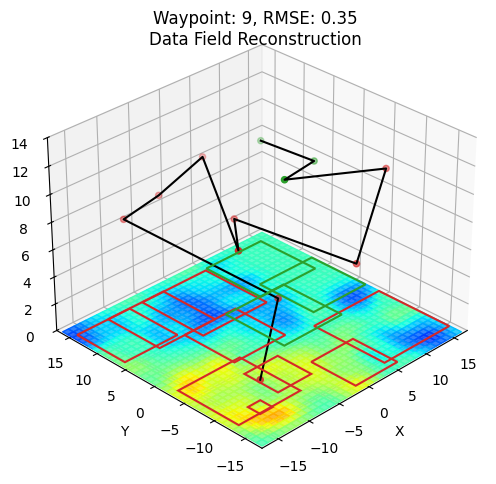

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.70746           │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [2.60946 5.92525] │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name   

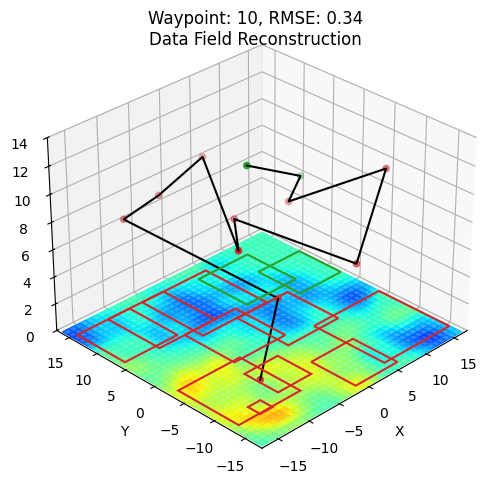

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.82939           │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [3.28849 3.3526 ] │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name   

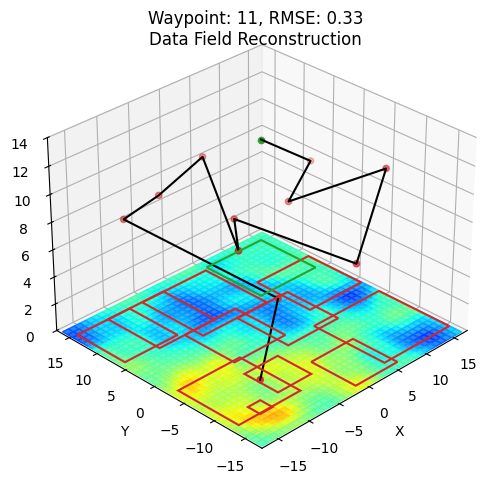

╒═════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤════════════════════╕
│ name                            │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value              │
╞═════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪════════════════════╡
│ SquaredExponential.variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.9424873907068891 │
├─────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼────────────────────┤
│ SquaredExponential.lengthscales │ Parameter │ Softplus    │         │ True        │ (2,)    │ float64 │ [4.27913 2.19189]  │
╘═════════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧════════════════════╛
╒═══════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ na

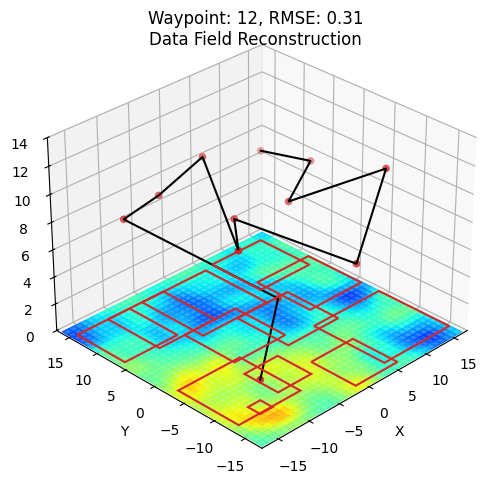

Total Hyperparameter Update Time:   29.67s
Total IPP Update Time:              26.14s
Average Hyperparameter Update Time: 2.47s
Average IPP Update Time:            2.18s


In [5]:
num_robots = 1
num_placements = 12
pts_per_side = 7  # Use a pts_per_side x pts_per_side point FoV approximation

# Setup the initial AIPP hyperparameters
print('Initial AIPP Hyperparameters')
_, noise_variance, kernel = get_model_params(X_train, y_train,
                                             lengthscales=[1.0, 1.0],
                                             max_steps=0)

# Get initial inducing points
Xu_init = get_inducing_pts(X_train, num_placements)
# Initialize the height dimension at 2.0 for all points
Xu_init = np.concatenate((Xu_init, np.ones((Xu_init.shape[0], 1)) * 2.0), axis=1)
paths, _ = run_tsp(Xu_init[:, :2])
if paths:
    Xu_init[:, :2] = paths[0]

# Initialize the non-point FoV transform
fov_transform = SquareHeightTransform(pts_per_side=pts_per_side)
transform = IPPTransform(num_dim=3,
                         num_robots=1,
                         sensor_model=fov_transform,
                         aggregate_fov=True)

# Initialize the IPP model using the new ContinuousSGP method
ipp_model = ContinuousSGP(
    num_sensing=num_placements,
    X_objective=X_train,
    noise_variance=noise_variance,
    kernel=kernel,
    transform=transform,
    X_init=Xu_init,
)

# Generate the SGP-based AIPP solution
_, _, param_time, ipp_time = run_aipp(X_train,
                                      ipp_model,
                                      Xu_init.reshape(1, -1, 3),
                                      dataset)

print(f'Total Hyperparameter Update Time:   {param_time:.2f}s')
print(f'Total IPP Update Time:              {ipp_time:.2f}s')

print(f'Average Hyperparameter Update Time: {param_time/num_placements:.2f}s')
print(f'Average IPP Update Time:            {ipp_time/num_placements:.2f}s')